In [5]:
# Automatically reload modules after executing each cell.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# General imports
import os
import tensorflow as tf
from scipy import stats

# Utility imports
from utils.losses import *
from utils.plotting import *
from utils.training import *

from flows.flows import *

np.random.seed(666) # Need to do more to ensure data is the same across runs.

In [7]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Training

## BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':4}
params_2 = {'loss':tanh_bce, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':4,  'output': 'linear'}

filestr = 'models/flows/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

if not os.path.isdir(filestr):
    os.mkdir(filestr)

if not os.path.isdir(filestr + 'sigmoid/'):
    os.mkdir(filestr + 'sigmoid/')
    
if not os.path.isdir(filestr + 'tanh/'):
    os.mkdir(filestr + 'tanh/')

if not os.path.isdir(filestr + 'arctan/'):
    os.mkdir(filestr + 'arctan/')

# Data parameters
N = 10**6
X = np.load('data/zenodo/X_trn.npy')[:N]
y = np.load('data/zenodo/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [ ]:
for i in range(reps):
    print(i, end = ' ')
    model_1, trace = train(data, **params_1)
    model_2, trace = train(data, **params_2)
    model_3, trace = train(data, **params_3)
    print()
    model_1.save_weights(filestr_1.format(i))
    model_2.save_weights(filestr_2.format(i))
    model_3.save_weights(filestr_3.format(i))

## MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':4}
params_2 = {'loss':tanh_mse, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':4,  'output': 'linear'}

filestr = 'models/flows/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

if not os.path.isdir(filestr):
    os.mkdir(filestr)

if not os.path.isdir(filestr + 'sigmoid/'):
    os.mkdir(filestr + 'sigmoid/')
    
if not os.path.isdir(filestr + 'tanh/'):
    os.mkdir(filestr + 'tanh/')

if not os.path.isdir(filestr + 'arctan/'):
    os.mkdir(filestr + 'arctan/')

# Data parameters
N = 10**6
X = np.load('data/zenodo/X_trn.npy')[:N]
y = np.load('data/zenodo/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [ ]:
for i in range(reps):
    print(i, end = ' ')
    model_1, trace = train(data, **params_1)
    model_2, trace = train(data, **params_2)
    model_3, trace = train(data, **params_3)
    print()
    model_1.save_weights(filestr_1.format(i))
    model_2.save_weights(filestr_2.format(i))
    model_3.save_weights(filestr_3.format(i))

## MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd': 4, 'output': 'linear'}

filestr = 'models/flows/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

if not os.path.isdir(filestr):
    os.mkdir(filestr)

if not os.path.isdir(filestr + 'relu/'):
    os.mkdir(filestr + 'relu/')
    
if not os.path.isdir(filestr + 'square/'):
    os.mkdir(filestr + 'square/')

if not os.path.isdir(filestr + 'exponential/'):
    os.mkdir(filestr + 'exponential/')

# Data parameters
N = 10**6
X = np.load('data/zenodo/X_trn.npy')[:N]
y = np.load('data/zenodo/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [ ]:
for i in range(reps):
    print(i, end = ' ')
    model_1, trace = train(data, **params_1)
    model_2, trace = train(data, **params_2)
    model_3, trace = train(data, **params_3)
    print()
    model_1.save_weights(filestr_1.format(i))
    model_2.save_weights(filestr_2.format(i))
    model_3.save_weights(filestr_3.format(i))

## SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd': 4, 'output': 'linear'}

filestr = 'models/flows/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

if not os.path.isdir(filestr):
    os.mkdir(filestr)

if not os.path.isdir(filestr + 'relu/'):
    os.mkdir(filestr + 'relu/')
    
if not os.path.isdir(filestr + 'square/'):
    os.mkdir(filestr + 'square/')

if not os.path.isdir(filestr + 'exponential/'):
    os.mkdir(filestr + 'exponential/')

# Data parameters
N = 10**6
X = np.load('data/zenodo/X_trn.npy')[:N]
y = np.load('data/zenodo/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [ ]:
for i in range(reps):
    print(i, end = ' ')
    model_1, trace = train(data, **params_1)
    model_2, trace = train(data, **params_2)
    model_3, trace = train(data, **params_3)
    print()
    model_1.save_weights(filestr_1.format(i))
    model_2.save_weights(filestr_2.format(i))
    model_3.save_weights(filestr_3.format(i))

# MAEs

In [8]:
#d = 4
#
#dat_target = make_target(d)
#sim_target = make_target(d)
#
#dat_ckpt = tf.train.Checkpoint(dat_target)
#sim_ckpt = tf.train.Checkpoint(sim_target)
#
#dat_ckpt.restore('flows/dat/ckpt-79')
#sim_ckpt.restore('flows/sim/ckpt-79')

In [9]:
lr = lambda x: tf.math.exp(dat_target.log_prob(x) - sim_target.log_prob(x)).numpy()

In [10]:
#%%time
#X_mae = np.load('data/zenodo/X_tst.npy')
#lr_tst = lr(X_mae)
#np.save('data/zenodo/lr_tst.npy', lr_tst)

In [11]:
X_mae = np.load('data/zenodo/X_tst.npy')
lr_tst = np.load('data/zenodo/lr_tst.npy')

In [12]:
def mae(model_lr):
    abs_dif = abs(model_lr(X_mae) - lr_tst)
    return abs_dif[abs_dif < 100].mean()

## BCE

In [15]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':4}
params_2 = {'loss':tanh_bce, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/X_trn.npy')[:N]
y = np.load('data/zenodo/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)

# Calculate mean absolute errors
#maes_1 = [mae(lr) for lr in lrs_1]
#maes_2 = [mae(lr) for lr in lrs_2]
#maes_3 = [mae(lr) for lr in lrs_3]
    
print('Absolute Differences')
abs_dif_1 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_1])
abs_dif_2 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_2])
abs_dif_3 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_3])

#avg_1 = np.mean(maes_1)
#avg_2 = np.mean(maes_2)
#avg_3 = np.mean(maes_3, where = ~np.isnan(maes_3))

# Save results
#np.save(filestr + 'avg_1.npy', avg_1)
#np.save(filestr + 'avg_2.npy', avg_2)
#np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'abs_dif_1.npy', abs_dif_1)
np.save(filestr + 'abs_dif_2.npy', abs_dif_2)
np.save(filestr + 'abs_dif_3.npy', abs_dif_3)

#avg_1, avg_2, avg_3

Absolute Differences


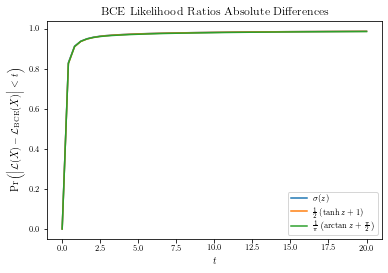

In [14]:
aa = abs_dif_1.flatten()
bb = abs_dif_2.flatten()
cc = abs_dif_3.flatten()

ts = np.linspace(0, 20)
plt.plot(ts, [(aa < t).mean() for t in ts], label = r'$\sigma(z)$')
plt.plot(ts, [(bb < t).mean() for t in ts], label = r'$\frac{1}{2}\left(\tanh{z} + 1\right)$')
plt.plot(ts, [(cc < t).mean() for t in ts], label = r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$')
plt.legend()

plt.xlabel(r'$t$')
plt.ylabel(r'$\text{Pr}\left(\Big|\mathcal{L}(X) - \mathcal{L}_\text{BCE}(X)\Big| < t\right)$')
plt.title(r'BCE Likelihood Ratios Absolute Differences')

plt.savefig('plots/bce_threshold_plot.png', 
            dpi=300, 
            bbox_inches='tight')

## MSE

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':4}
params_2 = {'loss':tanh_mse, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/X_trn.npy')[:N]
y = np.load('data/zenodo/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)

# Calculate mean absolute errors
#maes_1 = [mae(lr) for lr in lrs_1]
#maes_2 = [mae(lr) for lr in lrs_2]
#maes_3 = [mae(lr) for lr in lrs_3]

print('Absolute Differences')
abs_dif_1 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_1])
abs_dif_2 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_2])
abs_dif_3 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_3])

#avg_1 = np.mean(maes_1)
#avg_2 = np.mean(maes_2)
#avg_3 = np.mean(maes_3, where = ~np.isnan(maes_3))

# Save results
#np.save(filestr + 'avg_1.npy', avg_1)
#np.save(filestr + 'avg_2.npy', avg_2)
#np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'abs_dif_1.npy', abs_dif_1)
np.save(filestr + 'abs_dif_2.npy', abs_dif_2)
np.save(filestr + 'abs_dif_3.npy', abs_dif_3)

#avg_1, avg_2, avg_3

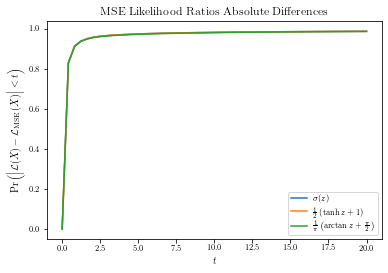

In [17]:
aa = abs_dif_1.flatten()
bb = abs_dif_2.flatten()
cc = abs_dif_3.flatten()

ts = np.linspace(0, 20)
plt.plot(ts, [(aa < t).mean() for t in ts], label = r'$\sigma(z)$')
plt.plot(ts, [(bb < t).mean() for t in ts], label = r'$\frac{1}{2}\left(\tanh{z} + 1\right)$')
plt.plot(ts, [(cc < t).mean() for t in ts], label = r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$')
plt.legend()

plt.xlabel(r'$t$')
plt.ylabel(r'$\text{Pr}\left(\Big|\mathcal{L}(X) - \mathcal{L}_\text{MSE}(X)\Big| < t\right)$')
plt.title(r'MSE Likelihood Ratios Absolute Differences')

plt.savefig('plots/mse_threshold_plot.png', 
            dpi=300, 
            bbox_inches='tight')

## MLC

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/X_trn.npy')[:N]
y = np.load('data/zenodo/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
print()

# Calculate mean absolute errors
#print('MAEs')
#maes_1 = [mae(lr) for lr in lrs_1]
#maes_2 = [mae(lr) for lr in lrs_2]
#maes_3 = [mae(lr) for lr in lrs_3]

print('Absolute Differences')
abs_dif_1 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_1])
abs_dif_2 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_2])
abs_dif_3 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_3])

#avg_1 = np.mean(maes_1)
#avg_2 = np.mean(maes_2)
#avg_3 = np.mean(maes_3, where = ~np.isnan(maes_3))

# Save results
#np.save(filestr + 'avg_1.npy', avg_1)
#np.save(filestr + 'avg_2.npy', avg_2)
#np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'abs_dif_1.npy', abs_dif_1)
np.save(filestr + 'abs_dif_2.npy', abs_dif_2)
np.save(filestr + 'abs_dif_3.npy', abd_dif_3)

#avg_1, avg_2, avg_3

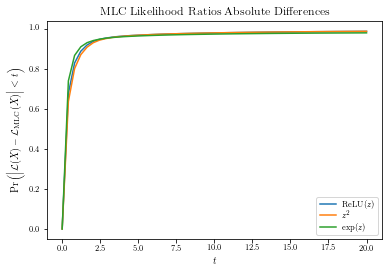

In [20]:
aa = abs_dif_1.flatten()
bb = abs_dif_2.flatten()
cc = abs_dif_3.flatten()

ts = np.linspace(0, 20)
plt.plot(ts, [(aa < t).mean() for t in ts], label = r'${\rm ReLU}(z)$')
plt.plot(ts, [(bb < t).mean() for t in ts], label = r'$z^2$')
plt.plot(ts, [(cc < t).mean() for t in ts], label = r'$\exp(z)$')
plt.legend()

plt.xlabel(r'$t$')
plt.ylabel(r'$\text{Pr}\left(\Big|\mathcal{L}(X) - \mathcal{L}_\text{MLC}(X)\Big| < t\right)$')
plt.title(r'MLC Likelihood Ratios Absolute Differences')

plt.savefig('plots/mlc_threshold_plot.png', 
            dpi=300, 
            bbox_inches='tight')

## SQR

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/X_trn.npy')[:N]
y = np.load('data/zenodo/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)

# Calculate mean absolute errors
#maes_1 = [mae(lr) for lr in lrs_1]
#maes_2 = [mae(lr) for lr in lrs_2]
#maes_3 = [mae(lr) for lr in lrs_3]

print('Absolute Differences')
abs_dif_1 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_1])
abs_dif_2 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_2])
abs_dif_3 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_3])

#avg_1 = np.mean(maes_1)
#avg_2 = np.mean(maes_2)
#avg_3 = np.mean(maes_3, where = ~np.isnan(maes_3))

# Save results
#np.save(filestr + 'avg_1.npy', avg_1)
#np.save(filestr + 'avg_2.npy', avg_2)
#np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'abs_dif_1.npy', abs_dif_1)
np.save(filestr + 'abs_dif_2.npy', abs_dif_2)
np.save(filestr + 'abs_dif_3.npy', abs_dif_3)

#avg_1, avg_2, avg_3

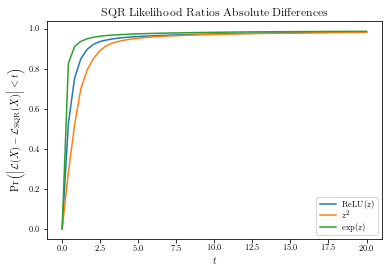

In [23]:
aa = abs_dif_1.flatten()
bb = abs_dif_2.flatten()
cc = abs_dif_3.flatten()

ts = np.linspace(0, 20)
plt.plot(ts, [(aa < t).mean() for t in ts], label = r'${\rm ReLU}(z)$')
plt.plot(ts, [(bb < t).mean() for t in ts], label = r'$z^2$')
plt.plot(ts, [(cc < t).mean() for t in ts], label = r'$\exp(z)$')
plt.legend()

plt.xlabel(r'$t$')
plt.ylabel(r'$\text{Pr}\left(\Big|\mathcal{L}(X) - \mathcal{L}_\text{SQR}(X)\Big| < t\right)$')
plt.title(r'SQR Likelihood Ratios Absolute Differences')

plt.savefig('plots/sqr_threshold_plot.png', 
            dpi=300, 
            bbox_inches='tight')

## AB MSE

In [ ]:
# Experiment parameters
num = 0
reps = 20

# File parameters
filestr = 'models/flows/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/X_trn.npy')[:N]
y = np.load('data/zenodo/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

In [ ]:
# Get model likelihood ratios.
avgs = []
for p in ps:
    print(p, end = '\t')
    lrs = [None] * reps
    params = {'loss':get_mse(p), 'd': 4}
    for i in range(reps):
        model = create_model(**params)
        model.load_weights(mse_filestr.format(p, i))
        lrs[i] = pow_odds_lr(model, p, m, s)
    
    maes = [mae(lr) for lr in lrs]
    avgs += [np.mean(maes)]

avgs = np.array(avgs)

In [ ]:
# Save results
np.save(filestr + 'avgs', avgs)

In [ ]:
avgs = np.load(filestr + 'avgs.npy')

In [ ]:
w = 3.5
h = 3.25              # Plots have dimension (w,h)

plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
plt.ylim(0, 1.25)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_zenodo.png', 
            dpi=300, 
            bbox_inches='tight')

## AB SQR

In [ ]:
# Experiment parameters
num = 0
reps = 20

# File parameters
filestr = 'models/flows/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/X_trn.npy')[:N]
y = np.load('data/zenodo/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

In [ ]:
lin_avgs = []
exp_avgs = []

for r in rs:
    print(r, end = '\t')
    lin_lrs = [None] * reps
    exp_lrs = [None] * reps
    lin_params = {'loss': get_sqr(r), 'd': 4, 'output':'relu'}
    exp_params = {'loss': get_exp_sqr(r), 'd': 4, 'output':'linear'}
    
    for i in range(reps):
        lin_model = create_model(**lin_params)
        exp_model = create_model(**exp_params)
        
        lin_model.load_weights(lin_filestr.format(r, i))
        exp_model.load_weights(exp_filestr.format(r, i))
        
        lin_lrs[i] = pow_lr(lin_model, r, m, s)
        exp_lrs[i] = pow_exp_lr(exp_model, r, m, s)
    
    lin_maes = [mae(lr) for lr in lin_lrs]
    exp_maes = [mae(lr) for lr in exp_lrs]
    
    lin_avgs += [np.mean(lin_maes)]
    exp_avgs += [np.mean(exp_maes)]

In [ ]:
# Save results
lin_avgs = np.array(lin_avgs)
exp_avgs = np.array(exp_avgs)

np.save(filestr + 'lin_avgs', lin_avgs)
np.save(filestr + 'exp_avgs', exp_avgs)

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_zenodo.png', 
            dpi=300, 
            bbox_inches='tight')

# Check NaNs

## BCE

In [4]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':4}
params_2 = {'loss':tanh_bce, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':4,  'output': 'linear'}

filestr = 'models/flows/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/X_trn.npy')[:N]
y = np.load('data/zenodo/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [ ]:
abs_dif_1 = np.load(filestr + 'abs_dif_1.npy', avg_1)
abs_dif_2 = np.load(filestr + 'abs_dif_2.npy', avg_2)
abs_dif_3 = np.load(filestr + 'abs_dif_3.npy', avg_3)

## Check Random Slice